# Building a LSTM by hand on PyTorch

[Source](https://towardsdatascience.com/building-a-lstm-by-hand-on-pytorch-59c02a4ec091)



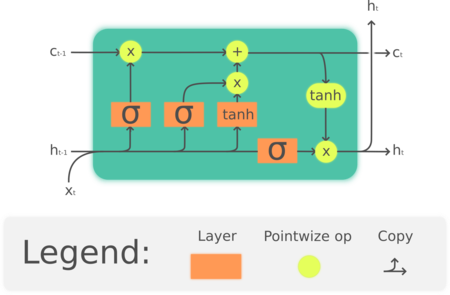

## Forget Gate

The forget gate is the one where the input information is operated along with the candidate, as the long term memory. See that, on the first linear combination of the input, hidden state and bias, it is applied a sigmoid function:

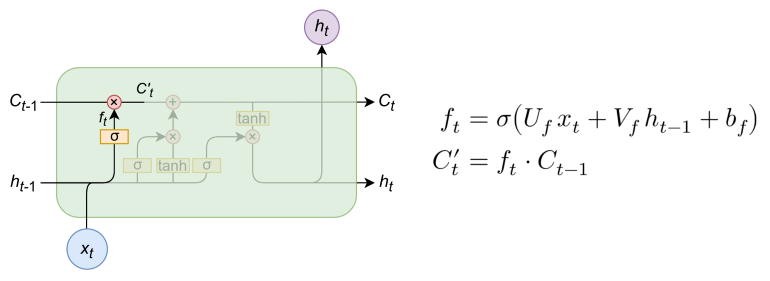

That sigmoid “scales” the output of the forget gate from 0 to 1 — and, by multiplying it with the candidate, we can either set it to zero, which represent a “forgetting” from the long time memory, or by a bigger number, which represent “how much” we are remembering from that long-term memory.

## Input Gate
**Solution of the new long-term memory**

The input gate is where the information contained on the input and hidden state is combined and then operated along with the candidate and partial candidate c’_t:

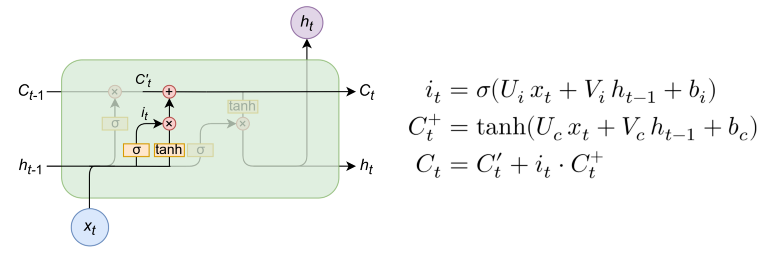

On those operations, it is decided how much of the new information will be introduced on the memory how it will change — that’s why we use a tanh function (“scale” from -1 to 1). We combine the partial candidate from the short-term and long-term memories and set it as the candidate.

## Output gate

After that, we can gather o_t as the output gate of the LSTM cell and then multiply it per the tanh of the candidate (long-term memory) which was already update with the proper operation. The output of network will be h_t.

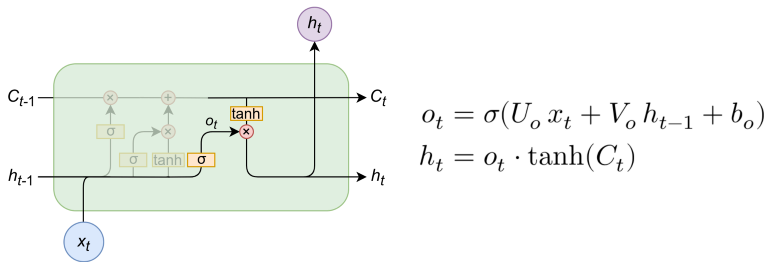

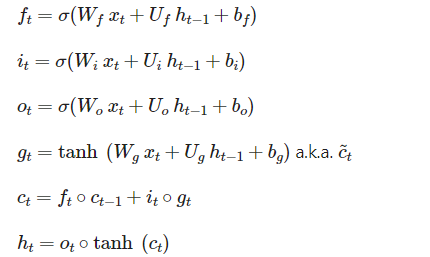

# Implementing it on PyTorch

In [1]:
!pip install pytorch-nlp

In [7]:
import torch
import torch.nn as nn
import torch.nn.functional as F
import torch.optim as optim

from torchnlp.encoders.text import SpacyEncoder, pad_tensor
from sklearn.model_selection import train_test_split

import pandas as pd
import numpy as np

import seaborn as sns
import matplotlib.pyplot as plt
%matplotlib inline


torch.manual_seed(0)
torch.backends.cudnn.deterministic = True
torch.backends.cudnn.benchmark = False
np.random.seed(0)

In [8]:
# Preprocessing

#import
df = pd.read_csv('data/Reviews.csv')

#drop useless data
df = df.drop(['Id', 'ProductId', 'UserId', 'ProfileName', 'HelpfulnessNumerator',
       'HelpfulnessDenominator', 'Time', 'Summary',], axis=1)

#remove ambiguous 3 and 4 stars for balancing
df = df[df['Score'] != 3]

FileNotFoundError: ignored

In [5]:
class NaiveCustomLSTM(nn.Module):
  def __init__(self, input_sz: int, hidden_sz: int):
    super().__init__()
    self.input_size = input_sz
    self.hidden_size = hidden_sz

    #f_t
    self.W_f = nn.Parameter(torch.Tensor(input_sz, hidden_sz))
    self.U_f = nn.Parameter(torch.Tensor(hidden_sz, hidden_sz))
    self.b_f = nn.Parameter(torch.Tensor(hidden_sz))

    #i_t
    self.W_i = nn.Parameter(torch.Tensor(input_sz, hidden_sz))
    self.U_i = nn.Parameter(torch.Tensor(hidden_sz, hidden_sz))
    self.b_i = nn.Parameter(torch.Tensor(hidden_sz))

    #c_t tuta = g_t
    self.W_c = nn.Parameter(torch.Tensor(input_sz, hidden_sz))
    self.U_c = nn.Parameter(torch.Tensor(hidden_sz, hidden_sz))
    self.b_c = nn.Parameter(torch.Tensor(hidden_sz))

    #c_t tuta = g_t
    self.W_o = nn.Parameter(torch.Tensor(input_sz, hidden_sz))
    self.U_o = nn.Parameter(torch.Tensor(hidden_sz, hidden_sz))
    self.b_o = nn.Parameter(torch.Tensor(hidden_sz))

    self.init_weights()

  def init_weights(self):
    stdv = 1.0 / math.sqrt(self.hidden_size)
    for weight in self.parameters():
      weight.data.uniform_(stdv)

  def forward(self, x, init_states=None):

    """
    assumes x.shape represents (batch_size, sequence_size, input_size)
    """
    ba, seq_sz, _ = x.size()
    hidden_seq = []

    if init_states is None:
      h_t, c_t = (
          torch.zeros(bs, self.hidden_size).to(x.device),
          torch.zeros(bs, self.hidden_size).to(x.device),
      )
    else:
      h_t, c_t = init_states 

    for t in range(seq_sz):
      x_t = x[:, t, :]

      i_t = torch.sigmoid(x_t @ self.W_i + h_t @ self.U_i + self.b_i)
      f_t = torch.sigmoid(x_t @ self.W_f + h_t @ self.U_f + self.b_f)
      g_t = torch.tanh(x_t @ self.W_c + h_t @ self.U_c + self.b_c)
      o_t = torch.sigmoid(x_t @ self.W_o + h_t @ self.U_o + self.b_o)
      c_t = f_t * c_t + i_t * g_t
      h_t = o_t * torch.tanh(c_t)

      hidden_seq.append(h_t.unsqueeze(0))

    #reshape hidden_seq p/ retornar
    hidden_seq = torch.cat(hidden_seq, dim=0)
    hidden_seq = hidden_seq.transpose(0, 1).contiguous()
    return hidden_seq, (h_t, c_t)

class Net(nn.Module):

  def __init__(self):
    super().__init__()
    self.embedding = nn.Embedding(len(encoder.vocab)+1, 32)
    self.lstm = NaiveCustomLSTM(32,32) 
    self.fc1 = nn.Linear(32, 2)

  def forward(self, x):
    x_ = self.embedding(x)
    x_, (h_n, c_n) = self.lstm(x_)
    x_ = (x_[:, -1, :])
    x_ = self.fc1(x_)
    return x_
